### 1. Import Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from ddpg_agent import Agent

### 2. Examine the State and Action Spaces

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]


# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Create an Instance of the Agent and define help functions to plot the rewards

In [3]:
seed = 2021
## init the agent
num_agents = len(env_info.agents)
agents = Agent(state_size, action_size, seed,num_agents)

#### Help functions for plot

In [4]:
def plot_score_graph(scores_list, avg_scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores_list)), scores_list, label = "scores")
    plt.plot(np.arange(len(avg_scores)), avg_scores, label = "100 moving average")
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    ax.hlines(y=30.0, xmin=0, xmax=len(scores_list), linewidth=2, color='r')
    plt.legend()
    plt.savefig('scores.png')

def plot_loss_graph(critic_loss, actor_loss):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plotting the line 1 points 
    plt.plot(np.arange(len(critic_loss)), critic_loss, label = "critic loss")
    plt.ylabel('Loss')
    plt.xlabel('Episode #')
    
    plt.savefig('losses_critic.png')
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # plotting the line 2 points 
    plt.plot(np.arange(len(actor_loss)), actor_loss, label = "actor loss")
    #plt.legend()
    
    plt.ylabel('Loss')
    plt.xlabel('Episode #')
    
    plt.savefig('losses_actor.png')

### 4. Training the Agent

In [5]:
from collections import namedtuple, deque 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
scores_list = []                    # list containing scores from each episode
actor_losses = []
critic_losses = []
avg_scores = []
scores_window = deque(maxlen=100)  # last 100 scores

for i_episode in range(1, 200+1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    agents.reset()
    while True:   
        actions = agents.act(states)                        # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += rewards                                  # update the score (for each agent)
        
        agents.step(states, 
                    actions, 
                    np.expand_dims(np.asarray(rewards), axis=1),
                    next_states, 
                    np.expand_dims(np.asarray(dones), axis=1)) # agent takes a step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
        
        states = next_states                               # roll over states to next time step
        
    
    scores_window.append(np.mean(scores))       # save most recent score in deque list
    scores_list.append(np.mean(scores))         # save most recent score
    avg_scores.append(np.mean(scores_window))
    actor_losses.append(agents.actor_loss[-1])
    critic_losses.append(agents.critic_loss[-1])
    
    clear_output(wait=True)
    #print(count)
    print('\rEpisode {}\t\tScore:{:.2f} \tAverage Score: {}\nAverage critic loss: {} \t Average actor loss: {}'.format(i_episode,np.mean(scores),
                                                                      np.mean(scores_window),
                                                                      np.mean(agents.critic_loss),
                                                                      np.mean(agents.actor_loss)),end="")
    if np.mean(scores)>= 30:
        with open('message.txt','a') as file:
            file.write('Solved in {} episodes\n'.format(i_episode))
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    if np.mean(scores_window)>=30.0:
        torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        break
    


Episode 103		Score:34.94 	Average Score: 30.31156932248361
Episode 103	Average Score: 30.31


#### Watching the Smart Agent

In [6]:
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

<All keys matched successfully>

In [7]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
agents.reset()
while True:   
    actions = agents.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += rewards                                  # update the score (for each agent)

    if np.any(dones):                                  # exit loop if episode finished
        break

    states = next_states                               # roll over states to next time step

#### Plotting the graph

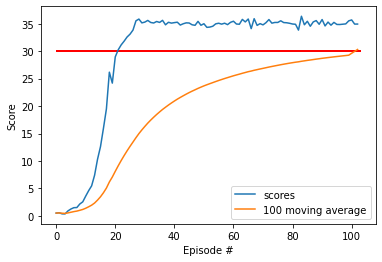

In [8]:
plot_score_graph(scores_list,avg_scores)

In [9]:
env.close()